In [9]:
from typing import List, Mapping
from itertools import zip_longest
from glob import glob

import pandas as pd
import numpy as np
from numpy.random import normal, choice, rand
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt
from h5py import File

from vmitools import (
    abel_inverse, finite_legendre_transform_in_theta,
    interp, tohist, transpose_linearly, transpose_to_drdomega, transpose_to_drdth,
    mrot, mhorshear, msqueeze,
)

In [11]:
run = 219
filenames = glob(f"/data/*/Run_{run:03d}/work/reduced_*.h5")
filenames

['/data/Step501N2/Run_219/work/reduced_dt=-6.610.h5',
 '/data/Step501N2/Run_219/work/reduced_dt=-6.580.h5',
 '/data/Step501N2/Run_219/work/reduced_dt=-6.550.h5',
 '/data/Step501N2/Run_219/work/reduced_dt=-6.520.h5',
 '/data/Step501N2/Run_219/work/reduced_dt=-6.490.h5',
 '/data/Step501N2/Run_219/work/reduced_dt=-6.460.h5',
 '/data/Step501N2/Run_219/work/reduced_dt=-6.430.h5',
 '/data/Step501N2/Run_219/work/reduced_dt=-6.400.h5',
 '/data/Step501N2/Run_219/work/reduced_dt=-6.370.h5',
 '/data/Step501N2/Run_219/work/reduced_dt=-6.340.h5',
 '/data/Step501N2/Run_219/work/reduced_dt=-6.310.h5',
 '/data/Step501N2/Run_219/work/reduced_dt=-6.280.h5',
 '/data/Step501N2/Run_219/work/reduced_dt=-6.250.h5',
 '/data/Step501N2/Run_219/work/reduced_dt=-6.220.h5',
 '/data/Step501N2/Run_219/work/reduced_dt=-6.190.h5',
 '/data/Step501N2/Run_219/work/reduced_dt=-6.160.h5',
 '/data/Step501N2/Run_219/work/reduced_dt=-6.130.h5',
 '/data/Step501N2/Run_219/work/reduced_dt=-6.100.h5']

In [12]:
def read_file(filename):
    with File(filename) as f:
        return {
            'delay': f['delay'].value,
            'df_n': f['df_n'][...],
            'df_img': f['df_img'][...],
        }


df = pd.DataFrame([read_file(fn) for fn in filenames])
df

,delay,df_img,df_n
0,-6.61,"[[4.703585016758765, 5.371007337621165, 4.2461...",1328
1,-6.58,"[[4.555486230636831, 4.7048147477126605, 4.016...",1328
2,-6.55,"[[4.206456456456451, 4.771771771771782, 3.8731...",2664
3,-6.52,"[[4.675809161730513, 3.8807888796483354, 4.120...",1329
4,-6.49,"[[4.567008276971592, 5.126824810275295, 4.0489...",2464
5,-6.46,"[[4.571428571428569, 5.489361702127653, 4.3601...",1316
6,-6.43,"[[4.322854898376022, 4.984269492808465, 4.2157...",2650
7,-6.40,"[[4.363103610911708, 4.755626186889955, 4.0901...",1203
8,-6.37,"[[4.156824271913123, 5.110261382601124, 3.8259...",2610
9,-6.34,"[[4.221073748956201, 5.123747711539721, 3.9788...",1327


In [13]:
zedges = np.arange(-400, 400 + 1)
redges, thedges = np.linspace(0, 400, 801), np.linspace(-np.pi, np.pi, 721)
r = (redges[1:] + redges[:-1]) / 2


def dist(img):
    img = img.T
    xn, yn = img.shape
    xedges = np.arange(xn + 1)
    yedges = np.arange(yn + 1)
    f = interp(img, xedges, yedges)
    g = transpose_linearly(f, np.eye(2), x0=np.array([437, 459]))
    transformed = tohist(g, zedges, zedges)

    dz = zedges[1:] - zedges[:-1]
    inverted = abel_inverse(transformed, zedges) * dz[None, :]  # shape: (r, z)
    sliced = interp(inverted, zedges, zedges)  # (rho, z) -> intensity
    hist_indrdomega = tohist(transpose_to_drdomega(sliced), redges, thedges)  # (r, th) -> intensity
    hist_indrdth = tohist(transpose_to_drdth(sliced), redges, thedges)  # (r, th) -> intensity
    _, coeff, _ = finite_legendre_transform_in_theta(
        hist_indrdomega.sum(0), thedges, 6,
    )  # Shapes of returns: (n, r) (n, r) (n, th)
    return hist_indrdth.sum(1)


df['dist'] = df['df_img'].apply(dist)

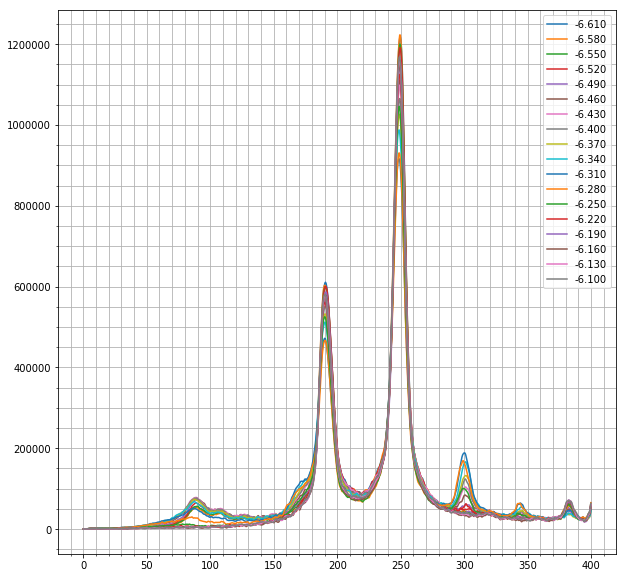

In [14]:
plt.figure(figsize=(10, 10))
for _, dt, dist in df[['delay', 'dist']].itertuples():
    plt.plot(r, dist, label=f"{dt:.3f}")
#     plt.plot(r**2, dist/2/r, label=f"{dt:.3f}")
plt.minorticks_on()
plt.grid(True, which='both')
plt.legend()
plt.show()

In [37]:
df.loc[0]['dist'][150:220]

array([15876.45238154, 16940.57059196, 17594.32043402, 18459.032873  ,
       19665.17269687, 20494.71163217, 20859.10370399, 21600.47823423,
       23161.79451311, 25079.89619525, 26673.87182143, 27884.06124745,
       29437.09530694, 31392.14983326, 33385.67355432, 36163.79014095,
       40235.65748971, 43995.77808067, 45529.20308058, 46003.32115714,
       47321.16885437, 48936.87817264, 50522.33232675, 52237.4226645 ,
       53514.30831978, 54436.89725976, 55267.4125278 , 55493.96657807,
       55038.48065347, 54421.91252176, 54019.46614947, 53634.95704822,
       52543.4769583 , 50754.64499847, 49367.54821422, 48908.11589904,
       48467.96583124, 47299.405451  , 45907.18914648, 44683.37205295,
       43330.02816785, 41879.54537911, 40805.71389527, 40183.78624019,
       39485.70492456, 38127.19772324, 36556.91659971, 35358.1170243 ,
       34058.03165072, 32938.01031374, 32647.90611085, 32985.04747972,
       33304.69983007, 33321.83641213, 33906.55559535, 35535.80894574,
      

No handles with labels found to put in legend.


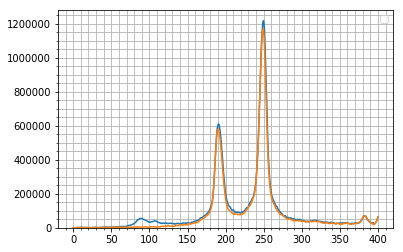

In [45]:
where = slice(None)
plt.plot(r[where], df.loc[0]['dist'][where])
plt.plot(r[where], df.loc[17]['dist'][where])
#     plt.plot(r**2, dist/2/r, label=f"{dt:.3f}")
plt.minorticks_on()
plt.grid(True, which='both')
plt.ylim(0, None)
plt.legend()
plt.show()

In [48]:
def intergrateit(dist, fr, to):
    where = (fr < r) & (r < to)
    return dist[where].sum()


df['summed0'] = df['dist'].apply(intergrateit, fr=160, to=180)
df['summed1'] = df['dist'].apply(intergrateit, fr=150, to=220)
df['summed2'] = df['dist'].apply(intergrateit, fr=230, to=270)
df['summed3'] = df['dist'].apply(intergrateit, fr=280, to=320)
df

,delay,df_img,df_n,dist,summed1,summed2,summed3,summed0
0,-6.61,"[[4.703585016758765, 5.371007337621165, 4.2461...",1328,"[6.53852435631132, 57.8927478935129, 151.64452...",2.315542e+07,3.495536e+07,3.711301e+06,2.666159e+06
1,-6.58,"[[4.555486230636831, 4.7048147477126605, 4.016...",1328,"[4.162640195201528, 37.715995835754605, 103.44...",2.306441e+07,3.505460e+07,3.644374e+06,2.650171e+06
2,-6.55,"[[4.206456456456451, 4.771771771771782, 3.8731...",2664,"[4.033813136593695, 38.11780401069353, 112.293...",2.257312e+07,3.390574e+07,3.479260e+06,2.596257e+06
3,-6.52,"[[4.675809161730513, 3.8807888796483354, 4.120...",1329,"[2.0360202720791105, 22.85621253403417, 82.052...",2.312074e+07,3.404011e+07,3.870657e+06,2.764805e+06
4,-6.49,"[[4.567008276971592, 5.126824810275295, 4.0489...",2464,"[3.6940113661434566, 35.571926621782055, 105.5...",2.240150e+07,3.234985e+07,3.971848e+06,2.781974e+06
5,-6.46,"[[4.571428571428569, 5.489361702127653, 4.3601...",1316,"[3.6811524593479352, 31.75283280071583, 82.970...",2.298299e+07,3.245754e+07,4.641644e+06,3.132845e+06
6,-6.43,"[[4.322854898376022, 4.984269492808465, 4.2157...",2650,"[3.011019685312318, 27.570921769443398, 79.636...",2.323668e+07,3.259091e+07,5.220038e+06,3.358041e+06
7,-6.40,"[[4.363103610911708, 4.755626186889955, 4.0901...",1203,"[3.1229630652857105, 28.2773578250116, 78.7351...",2.267734e+07,3.149879e+07,5.445514e+06,3.472882e+06
8,-6.37,"[[4.156824271913123, 5.110261382601124, 3.8259...",2610,"[2.8120783379036554, 27.465317478166074, 84.75...",2.219253e+07,3.048366e+07,5.791793e+06,3.566722e+06
9,-6.34,"[[4.221073748956201, 5.123747711539721, 3.9788...",1327,"[3.1242572602970133, 26.10387733407081, 65.972...",2.214569e+07,3.002039e+07,6.596457e+06,3.915774e+06


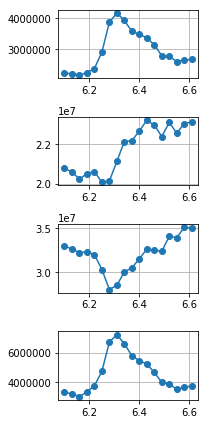

In [51]:
plt.figure(figsize=(3, 6))
for i in range(0, 4):
    plt.subplot(4, 1, i+1)
#     plt.title(f'{df["delay"]:.3f}')
    plt.plot(-df["delay"], df[f"summed{i}"], 'o-')
    plt.grid(True)
#     plt.ylim(0, None)
# plt.figlegend()
plt.tight_layout()
plt.show()